# Data Mining (2024-2025): Part 2 - Credit Card Default Classification
by Ahmad Bafakih <br>
Student ID: 33766650 <br>
I worked and submitted alone

In [2]:
# import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.model_selection import cross_validate, StratifiedKFold, GridSearchCV
import joblib

## Dataset Exploration and Preparation

In [2]:
# load in train and test dataset 
creditdefault_train = pd.read_csv('./creditdefault_dataset/creditdefault_train.csv')
creditdefault_test = pd.read_csv('./creditdefault_dataset/creditdefault_test.csv')

# print dataset sizes
print('Train dataset shape:', creditdefault_train.shape)
print('Test dataset shape:', creditdefault_test.shape)

# show first 5 samples
creditdefault_train.head()

Train dataset shape: (15000, 24)
Test dataset shape: (15000, 24)


,Y,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,X14,X15,X16,X17,X18,X19,X20,X21,X22,X23
0,1,20000,2,2,1,24,2,2,-1,-1,...,689,0,0,0,0,689,0,0,0,0
1,0,50000,2,2,1,37,0,0,0,0,...,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000
2,0,50000,1,2,1,57,-1,0,-1,0,...,35835,20940,19146,19131,2000,36681,10000,9000,689,679
3,0,50000,1,1,2,37,0,0,0,0,...,57608,19394,19619,20024,2500,1815,657,1000,1000,800
4,0,500000,1,1,2,29,0,0,0,0,...,445007,542653,483003,473944,55000,40000,38000,20239,13750,13770


Check train and test dataset for any null values which would hinder the training process. Since it does not, imputing will not be necessary as there are no values to fill.

In [3]:
creditdefault_train.isnull().sum().sum()

0

In [4]:
creditdefault_test.isnull().sum().sum()

0

Considering this is a binary classification task, it is necessary to check for class imbalance to achieve the best model possible. As you can see below, there is a huge class imbalance between defaulters and non-defaulters. Techniques like stratified samlping will have to be implemented to counter this.

In [5]:
print(creditdefault_train['Y'].value_counts())
print(creditdefault_test['Y'].value_counts())

Y
0    11682
1     3318
Name: count, dtype: int64
Y
0    11682
1     3318
Name: count, dtype: int64


In [6]:
# Data splitting
# train splits
creditdefault_train_y = creditdefault_train['Y']
creditdefault_train_X = creditdefault_train.drop('Y', axis=1)

# test splits
creditdefault_test_y = creditdefault_test['Y']
creditdefault_test_X = creditdefault_test.drop('Y', axis=1)

In [7]:
print('creditdefault_train_X shape:', creditdefault_train_X.shape)
print('creditdefault_train_y shape:', creditdefault_train_y.shape, '\n')
print('creditdefault_test_X shape:', creditdefault_test_X.shape)
print('creditdefault_test_y shape:', creditdefault_test_y.shape)

creditdefault_train_X shape: (15000, 23)
creditdefault_train_y shape: (15000,) 

creditdefault_test_X shape: (15000, 23)
creditdefault_test_y shape: (15000,)


In [8]:
# maybe scale here

## Build Functions

In [45]:
def plot(title, xlabel, ylabel, x, y):
    plt.clf()
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.plot(x, y)
    plt.show()

## Model 1: K-nearest neighbour

### Hyperparameter Tuning with Grid Search

With the data clean and ready for learning, we can now begin building predictive models. The first classifier I will be implementing will be K-nearest neighbour. Ultimately, the goal is to build the best predictive model using cross-validation; however, a few steps is necessary before we can implement cross-validation and do a final model selection and evaluation.

First, the initial experimentation will consist of using `GridSearchCV` to train multiple models with different values of `n_neighbours` and `power q`. I will be exploring 2 hyperparamter settings: `n_neigbors` and `p`. Both will be experimeted with values from 1 through 10 meaning there will be (10x10) possible hyperparameter settings and (10x10x5) model evaluations.

The model evaluations comes from 5-fold cross validation. Since the dataset has a massive class imbalance, `StratifiedKFold` will be implemented with the grid search.

In [9]:
# prepare param_grid for grid search
param_grid = {'n_neighbors': list(range(1, 11)),
               'p': list(range(1, 11))}

# Define Stratified K-Fold (5 splits)
stratified_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# define grid search
KNN_GSCV = GridSearchCV(KNeighborsClassifier(), param_grid=param_grid, scoring='accuracy', n_jobs=6, cv=stratified_kf)

# fit data to the model
KNN_GSCV.fit(X=creditdefault_train_X, y=creditdefault_train_y)
print ('best parameters for k-nearest neighbour is', KNN_GSCV.best_params_) 

best weights and n_neighbor counts is {'n_neighbors': 10, 'p': 1}


In [40]:
# save results object for further processing
results = KNN_GSCV.cv_results_
# print keys
print(results.keys())
# isolate results for n_neigbors = 1 and 10 for graphing
results_n1 = results['mean_test_score'][:10]
results_n10 = results['mean_test_score'][-10:]

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_n_neighbors', 'param_p', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score'])


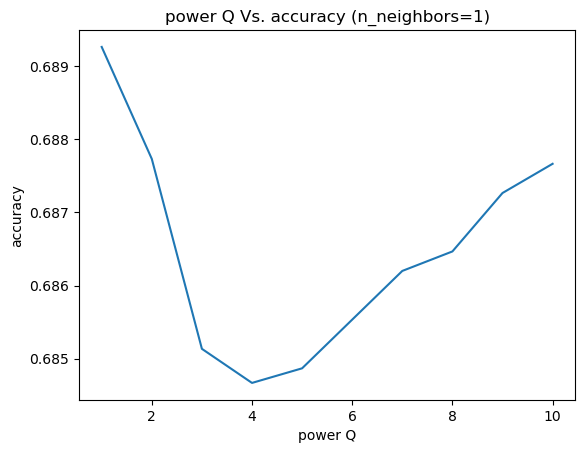

In [49]:
# x-axis values with respect to power of Q's experimented on
plot_x = list(range(1, 11))
# plot charts
plot('power Q Vs. accuracy (n_neighbors=1)', 'power Q', 'accuracy', plot_x, results_n1)

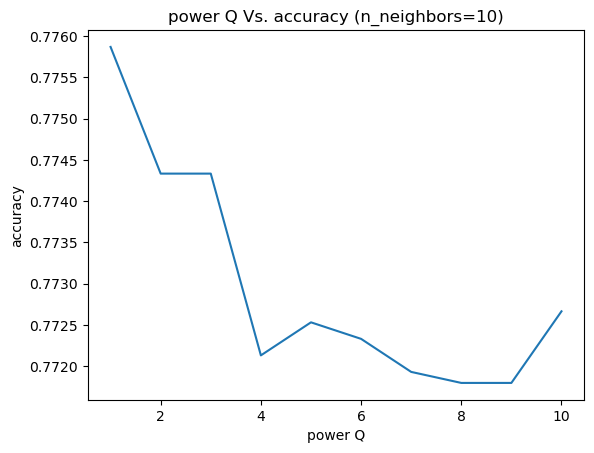

In [44]:
plot('power Q Vs. accuracy (n_neighbors=10)', 'power Q', 'accuracy', plot_x, results_n10)

The graphs above show that in both models, n_neighbors=1 and n_neighbors=10, the accuracy at its highest is at power Q=1. As Q increases, accuracy decreases and achieves its lowest scores between Q=4 and Q=9. This means the manhatten distance is the best distance evaluater for both cases.

In [4]:
# Save fitted GridSearchCV object
#joblib.dump(KNN_GSCV, "KNN_GSCV_model.pkl")

### Final Model Selection and Evaluation 

Since we now know the best parameters for the knn model, we can train the best model once more on the full train dataset and evaluate it on the train set.

In [47]:
# get best model from GridSearchCV
KNN_best = KNN_GSCV.best_estimator_

# fit training full training data on it
KNN_best.fit(creditdefault_train_X, creditdefault_train_y)

# create prediction on test y
predictions = KNN_best.predict(creditdefault_test_X)

# compute accuracy between predictions and true labels
accuracy = accuracy_score(creditdefault_test_y, predictions)

# print final accuracy score
print('Final accuracy score:', accuracy)

Final accuracy score: 0.7766


## Model 2: Decision Trees

### Hyperparameter Tuning with Grid Search

The second classifier I will be exploring is Decision Trees. Again, ultimately the goal is to find the best estimator by finding the best hyperparameters through an extensive grid search. Five different hyperparameters will be looked at: criterion, splitter, max_depth, min_samples_split, and min_samples_leaf.

Within this grid search all supported criterion and splitter algorithms will be looked at. In the case of max_depth, we will explore certain multiples of 2 and "None" . This is due to the fact that increments of 1 or a small number wouldnt yield much varience and is not worth the computing power. The same can be said for min_samples_split and min_samples_leaf.

The model evaluations will also comesfrom 5-fold cross validation. Since the dataset has a massive class imbalance, `StratifiedKFold` will be implemented once more.

In [ ]:
# prepare param_grid for grid search
param_grid = {'criterion': ['gini', 'entropy', 'log_loss'],
              'splitter': ['best', 'random'],
              'max_depth': [1, 2, 4, 8, 16, 32, None],
              'min_samples_split': [2, 5, 10],   
              'min_samples_leaf': [1, 5, 10]}

# Define Stratified K-Fold (5 splits)
# stratified_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# define grid search
DT_GSCV = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, scoring='accuracy', n_jobs=6, cv=stratified_kf)

# fit data to the model
DT_GSCV.fit(X=creditdefault_train_X, y=creditdefault_train_y)
print ('best parameters for decision trees is', DT_GSCV.best_params_) 

In [ ]:
# save results object for further processing
results = DT_GSCV.cv_results_
# print keys
print(results.keys())

### Final Model Selection and Evaluation 

In [ ]:
# get best model from GridSearchCV
DT_GSCV = DT_GSCV.best_estimator_

# fit training full training data on it
DT_GSCV.fit(creditdefault_train_X, creditdefault_train_y)

# create prediction on test y
predictions = DT_GSCV.predict(creditdefault_test_X)

# compute accuracy between predictions and true labels
accuracy = accuracy_score(creditdefault_test_y, predictions)

# print final accuracy score
print('Final accuracy score:', accuracy)

## Model 3: Xgboost